Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import re
import seaborn as sns

##Загрузка датасета


In [ ]:
all = pd.read_csv('/content/all_a.csv', sep = ',')
all

,text_new,complexity
0,я звать георгий бессонов,Легкие тексты
1,мой маленький сосед дом лариса сев часто заход...,Легкие тексты
2,мы пить чай разговаривать о весь свет как сев ...,Легкие тексты
3,и нужный время хватать,Легкие тексты
4,и решить рассказать ребята мир деньга,Легкие тексты
...,...,...
11658,указание цель оценка эффективность рационально...,Магистратура
11659,являться один форма финансовый контроль госуда...,Магистратура
11660,это связать гфк являться объективный необходим...,Магистратура
11661,объём контрольный деятельность форма метод охв...,Магистратура


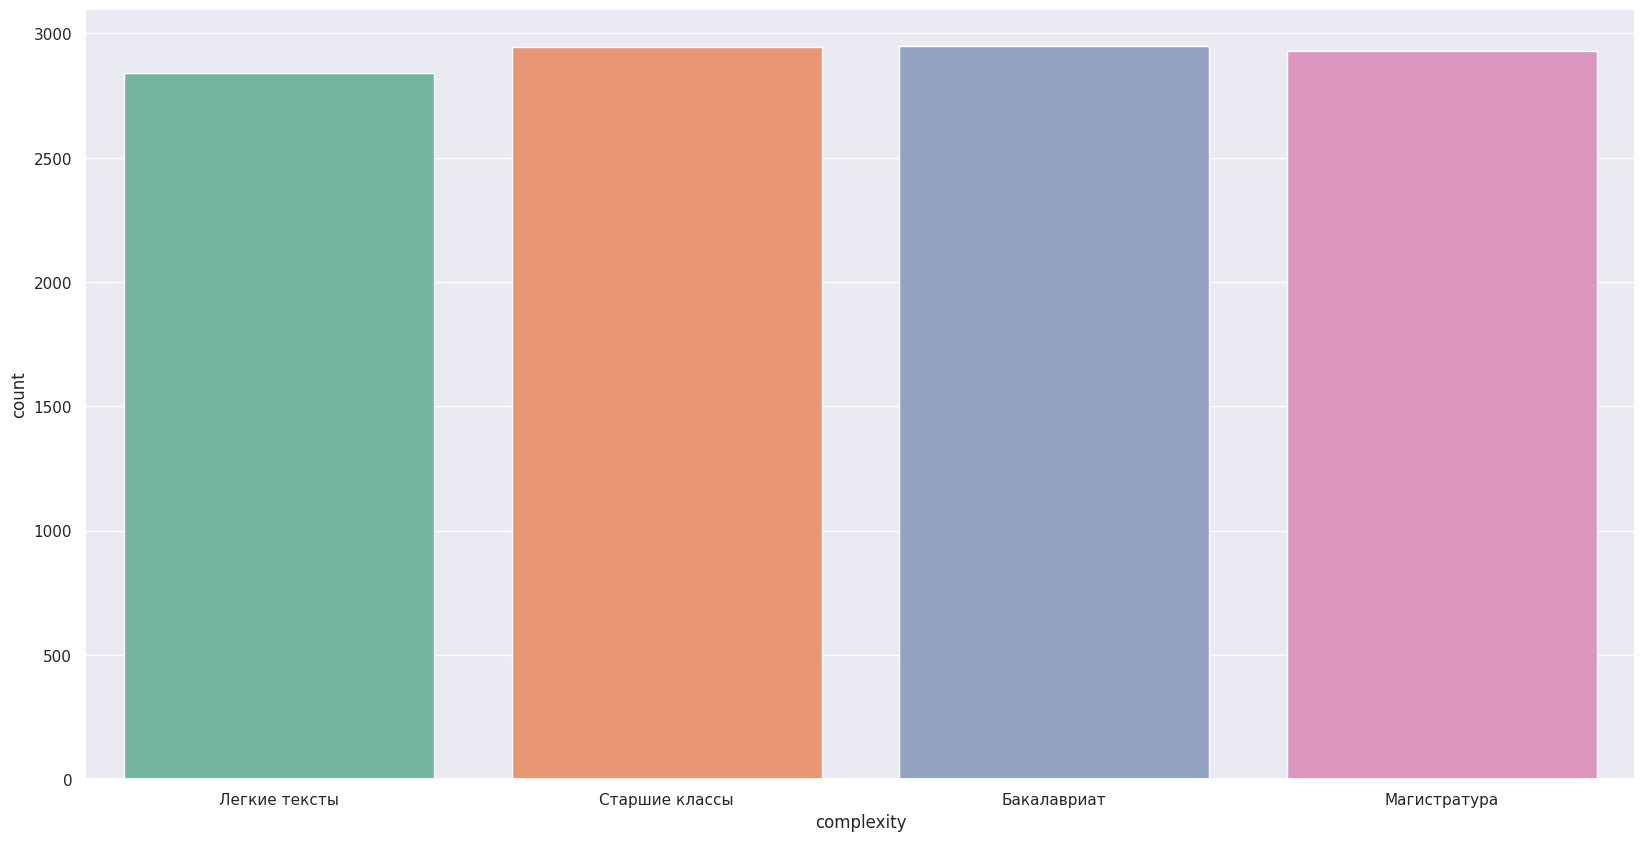

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='complexity', data = all, palette="Set2")

# Pipeline

In [ ]:
from sklearn.model_selection import train_test_split

X = all['text_new']
y = all['complexity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.3)

In [ ]:
X_train

10222    продолжать реформа наш электроэнергетика важно...
7797     в данный случай производственный функция демон...
3668     так случай фёдор открыть вклад накопительный в...
4365     с такой банк иметь дело в справочник кредитный...
1023                               выходить второй вариант
                               ...                        
11284    речь идти обеспечение гражданин электричество ...
5191     пеня начисляться тот пора пока уплатить весь с...
5390     перевести накопление негосударственный пенсион...
860                           поэтому происходить инфляция
7270     в второй случай конкурент мочь следовать фирма...
Name: text_new, Length: 8164, dtype: object

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
logreg = Pipeline([
                ('vect', CountVectorizer(analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=3,C=1e5, solver='saga', 
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=42)),
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

themes = all['complexity'].unique()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test, y_pred, target_names = themes))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

                precision    recall  f1-score   support

 Легкие тексты       0.50      0.48      0.49       872
Старшие классы       0.55      0.56      0.55       849
   Бакалавриат       0.51      0.56      0.53       867
  Магистратура       0.47      0.44      0.45       911

      accuracy                           0.51      3499
     macro avg       0.51      0.51      0.51      3499
  weighted avg       0.51      0.51      0.51      3499

F1 Score: 0.5061902128577086


# catboost 

In [ ]:
!pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.1 MB/s eta 0:00:00


In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool

def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(task_type='CPU', iterations = 5000,
                               eval_metric='TotalF1', od_type='Iter', 
                               od_wait=500, **kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)

In [ ]:
X_train.reset_index(drop=True, inplace= True)

In [ ]:
y_train.reset_index(drop= True , inplace= True )

In [ ]:
xr = pd.concat([X_train], ignore_index=True)
yr = pd.concat([y_train], ignore_index=True)

In [ ]:
train_pool = Pool(data=xr, label=yr, text_features = [0])

In [ ]:
xe = pd.concat([X_test], ignore_index=True)
ye = pd.concat([y_test], ignore_index=True)

In [ ]:
valid_pool = Pool(data = xe, label = ye, text_features = [0])

In [ ]:
model = fit_model(train_pool, valid_pool, learning_rate=0.35,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                 feature_calcers = ['BoW:top_tokens_count=1000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3567183	test: 0.3612934	best: 0.3612934 (0)	total: 435ms	remaining: 36m 12s
100:	learn: 0.7850507	test: 0.7481093	best: 0.7481093 (100)	total: 55.1s	remaining: 44m 33s
200:	learn: 0.8241227	test: 0.7586196	best: 0.7588918 (184)	total: 1m 21s	remaining: 32m 34s
300:	learn: 0.8491170	test: 0.7675739	best: 0.7684616 (297)	total: 1m 48s	remaining: 28m 18s
400:	learn: 0.8634966	test: 0.7742248	best: 0.7748196 (397)	total: 2m 15s	remaining: 25m 57s
500:	learn: 0.8753466	test: 0.7790020	best: 0.7790188 (498)	total: 2m 46s	remaining: 24m 53s
600:	learn: 0.8875748	test: 0.7809620	best: 0.7829343 (577)	total: 3m 13s	remaining: 23m 37s
700:	learn: 0.8961040	test: 0.7778456	best: 0.7829343 (577)	total: 3m 44s	remaining: 22m 55s
800:	learn: 0.9053404	test: 0.7772972	best: 0.7829343 (577)	total: 4m 12s	remaining: 22m 2s
900:	learn: 0.9123794	test: 0.7789728	best: 0.7829343 (577)	total: 4m 40s	remaining: 21m 13s
1000:	learn: 0.9190087	test: 0.7764328	best: 0.7829343 (577)	total: 5m 9s	rem

# SVC

In [ ]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [ ]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [ ]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  81.66
F1 (Polynomial Kernel):  81.75


In [ ]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  73.58
F1 (RBF Kernel):  73.70


In [ ]:
print(metrics.classification_report(y_test, rbf_pred, target_names=all['complexity'].unique()))

                precision    recall  f1-score   support

 Легкие тексты       0.83      0.69      0.75      1006
Старшие классы       0.69      0.73      0.71       923
   Бакалавриат       0.89      0.65      0.75       992
  Магистратура       0.62      0.88      0.73       928

      accuracy                           0.74      3849
     macro avg       0.76      0.74      0.74      3849
  weighted avg       0.76      0.74      0.74      3849



In [ ]:
print(f"F1 Score: {f1_score(y_test, rbf_pred, average='weighted')}")

F1 Score: 0.7370104400803792


# RandomForestClassifier, LinearSVC(), MultinomialNB(), LogisticRegression - общая оценка


In [ ]:
all['category_id'] = all['complexity'].factorize()[0]
category_id = all[['complexity', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id.values)
id_to_category = dict(category_id[['category_id', 'complexity']].values)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(random_state=0,  max_iter=500000),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', max_iter=500000),
]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features = tfidf.fit_transform(all.text_new).toarray()
labels = all.complexity

In [ ]:
CV = 7
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

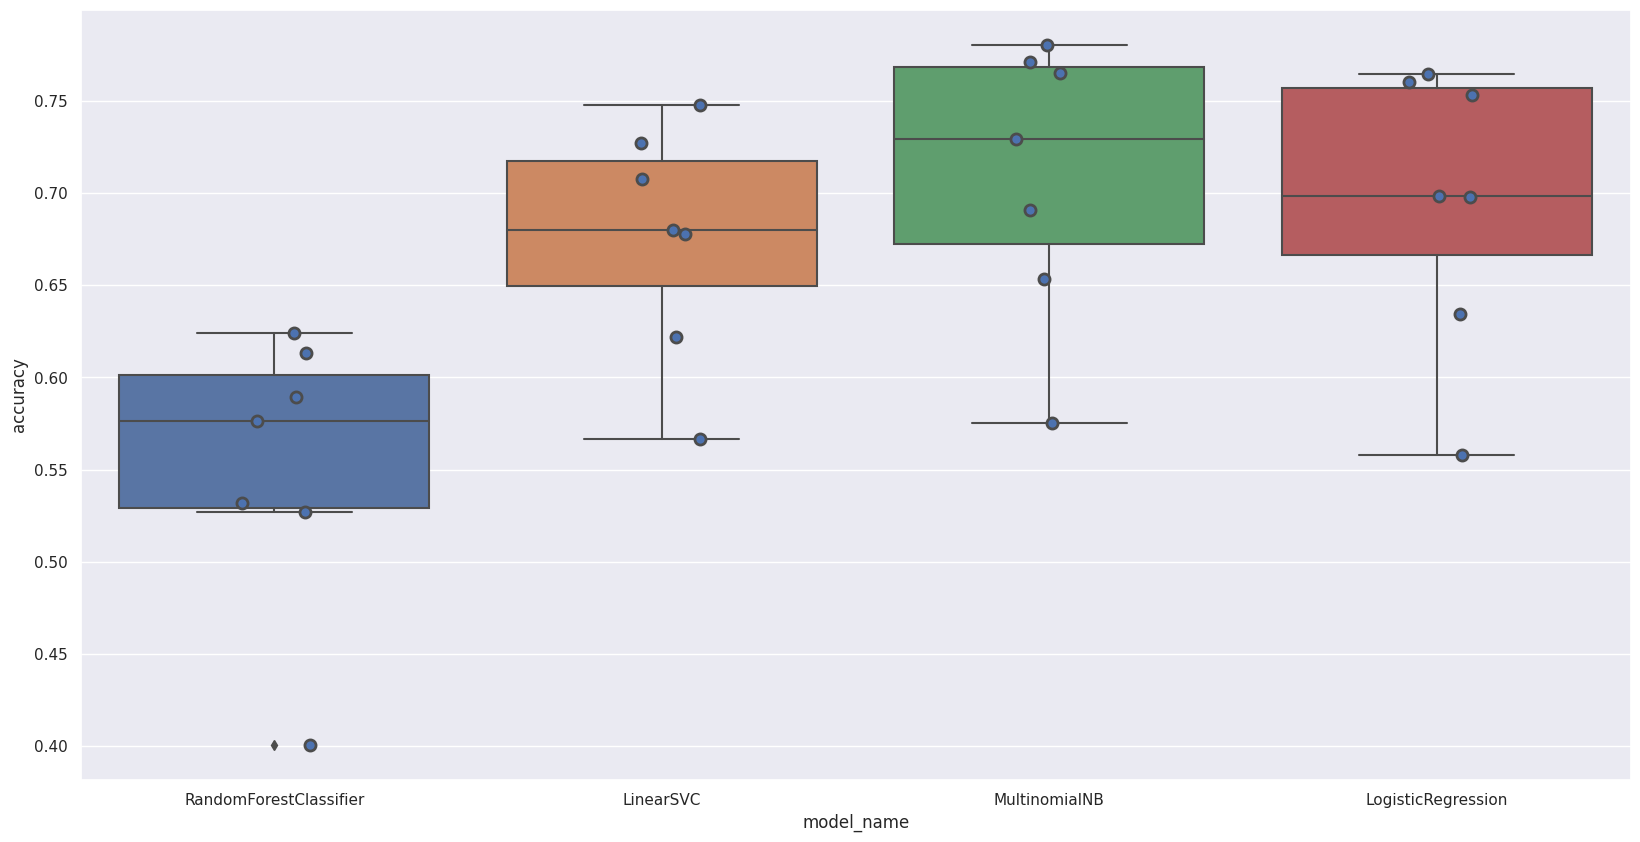

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Из блочной диаграммы видно, что точность классификатора случайных лесов самая низкая, т.к. случайный лес относится к интегральному классификатору (объединено несколько подклассификаторов), как правило, интегральный классификатор не подходит для обработки многомерных данных. (например, текстовые данные), потому что текстовые данные имеют слишком много собственных значений, что затрудняет работу интегрированного классификатора, а средняя точность трех других классификаторов около 70%. Среди них наибольшей точностью обладает MultinomialNB.



In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.675564
LogisticRegression        0.695373
MultinomialNB             0.709434
RandomForestClassifier    0.551844
Name: accuracy, dtype: float64

# После общей оценки моделей, обучим каждую отдельно для получения более 

Результаты (реализацию можно увидеть ниже)

KNeighborsClassifier (лучшая точность - бакалавриат)

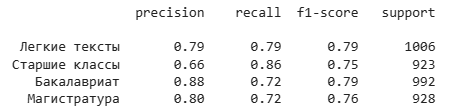

LogisticRegression (лучшая точность - магистратура, точность бакалавриата выше у случайных соседей)

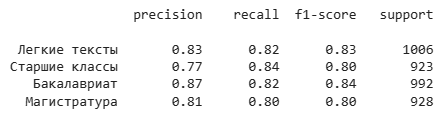

MultinomialNB() (лучшая точность - старшие классы, точность других выше у других моделей)

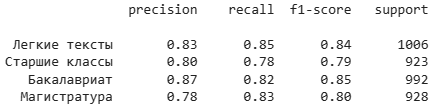

LinearSVC() (лучшая точность - легкие тексты)

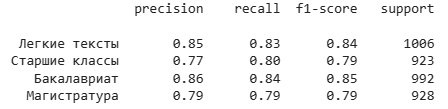

RandomForestClassifier()

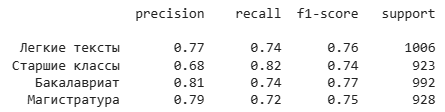

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 

# Выбираем модель
model = RandomForestClassifier() 

# Делим данные на тестовую и обучающую выборки
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all.index, test_size=0.33, random_state=0)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics

# Оценка модели
print(metrics.classification_report(y_test, y_pred, target_names=all['complexity'].unique()))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

                precision    recall  f1-score   support

 Легкие тексты       0.77      0.74      0.76      1006
Старшие классы       0.68      0.82      0.74       923
   Бакалавриат       0.81      0.74      0.77       992
  Магистратура       0.79      0.72      0.75       928

      accuracy                           0.76      3849
     macro avg       0.76      0.76      0.76      3849
  weighted avg       0.76      0.76      0.76      3849

F1 Score: 0.7575837425123144


# Реализация оценки сложности текстов

In [ ]:
df = all

df['category_id'] = all['complexity'].factorize()[0]
category_id = df[['complexity', 'category_id']].drop_duplicates().sort_values('category_id')

In [ ]:
id_to_category = dict(category_id[['category_id', 'complexity']].values)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id.complexity.values, yticklabels=category_id.complexity.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Можно оценить случайные тексты на сложность

texts = ['инфляция', 'экономика']
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

In [ ]:
# Выводим результат оцениваемых текстов, к какому классы они относятся
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(category_to_id[predicted]))

 # Создаем ансамбль 

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

all_kn = all[all['complexity'] == 'Бакалавриат']
all_lr = all[all['complexity'].isin(['Магистратура', 'Старшие классы'])] 
all_ls = all[all['complexity'].isin(['Легкие тексты', 'Магистратура'])] 
all_mn = all[all['complexity'] == 'Старшие классы']

features_kn = tfidf.fit_transform(all_kn.text_new).toarray()
features_lr = tfidf.fit_transform(all_lr.text_new).toarray()
features_ls = tfidf.fit_transform(all_ls.text_new).toarray()
features_mn = tfidf.fit_transform(all_mn.text_new).toarray()


# Разделяем данные на TRAIN и TEST
X_train_kn, X_test_kn, y_train_kn, y_test_kn, indices_train_kn, indices_test_kn = train_test_split(features_kn, all_kn.complexity, all_kn.index, test_size=0.33, random_state=0)
X_train_lr, X_test_lr, y_train_lr, y_test_lr, indices_train_lr, indices_test_lr = train_test_split(features_lr, all_lr.complexity, all_lr.index, test_size=0.33, random_state=0)
X_train_ls, X_test_ls, y_train_ls, y_test_ls, indices_train_ls, indices_test_ls = train_test_split(features_ls, all_ls.complexity, all_ls.index, test_size=0.33, random_state=0)
X_train_mn, X_test_mn, y_train_mn, y_test_mn, indices_train_mn, indices_test_mn = train_test_split(features_mn, all_mn.complexity, all_mn.index, test_size=0.33, random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all.index, test_size=0.33, random_state=0)
# Создаем классификатор KNN
k_neighbors = KNeighborsClassifier(n_neighbors=100, metric='minkowski', p=2, weights='uniform')

# Создаем классификатор LogisticRegression
logistic_regression = LogisticRegression(max_iter=500000)

# Создаем классификатор LinearSVC
linear_svс = LinearSVC(max_iter=500000)

# Создаем классификатор MultinomialNB
multinomial_nb = MultinomialNB()

# Обучаем классификаторы на данных
k_neighbors.fit(X_train_kn, y_train_kn)
logistic_regression.fit(X_train_lr, y_train_lr)
linear_svс.fit(X_train_ls, y_train_ls)
multinomial_nb.fit(X_train_mn, y_train_mn)

# Создаем ансамбль
clf = VotingClassifier(estimators=[('knn', k_neighbors), ('logistic', logistic_regression), ('linear', linear_svс), ('multi', multinomial_nb)], voting='hard')

# Обучение и оценка ансамбля
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=all['complexity'].unique()))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

                precision    recall  f1-score   support

 Легкие тексты       0.81      0.86      0.83      1006
Старшие классы       0.76      0.84      0.80       923
   Бакалавриат       0.89      0.81      0.84       992
  Магистратура       0.83      0.78      0.80       928

      accuracy                           0.82      3849
     macro avg       0.82      0.82      0.82      3849
  weighted avg       0.82      0.82      0.82      3849

F1 Score: 0.820787216701162


# Сохраняем модель и векторизатор

In [ ]:
import pickle

# создаем векторизатор и преобразуем данные
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
X = vectorizer.fit_transform(all.text_new)

# сохраняем векторизатор
with open('/content/vectorizer2.pk', 'wb') as f:
    pickle.dump(vectorizer, f)

# сохраняем преобразованные данные
with open('/content/data.pk', 'wb') as f:
    pickle.dump(y_pred, f)

# сохраняем модель
with open('/content/model.sav', 'wb') as f:
    pickle.dump(clf, f)